### Sampling all terms
To check that revesible jump is giving me a consistent answer, I will look at the posterior of K_1 without using reversible jump. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db
import torsionfit.plots as plots
from parmed.topologyobjects import DihedralType
from pymc import MCMC
from pymbar.timeseries import detectEquilibration
import numpy as np

Generate toy model that only allows 0 or 180 phases but allows all multiplicities to be on

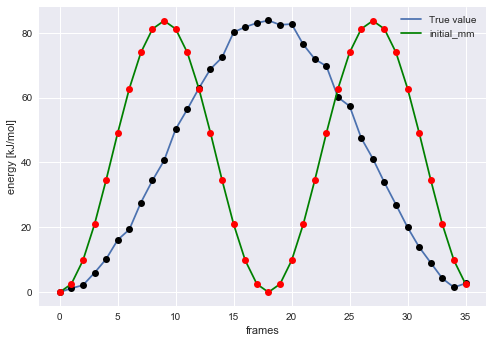

In [2]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1),
               n_increments=18, sample_phase=True, rj=False)
plt.plot(toy.synthetic_energy, label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

In [3]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='discrete_phase.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 372.0 sec

In [4]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)
print('Fit value')
print(toy.model.pymc_parameters['CG331_CG321_CG321_CG331_1_K'].value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralTypes [<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>]>
Fit value
10.123044020442462


With discrete phase proposals torsionfit does not gives a good fit even if all labels are off. 

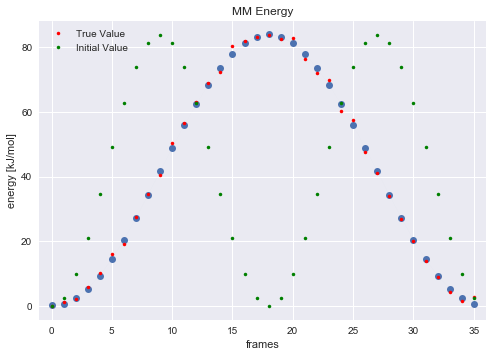

In [5]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.legend()
plt.savefig('energy_fit_discrete.pdf')

In [6]:
import pymbar.timeseries as ts
[t, g, N_eff] = ts.detectEquilibration(sampler.trace('sigma')[:])
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 116


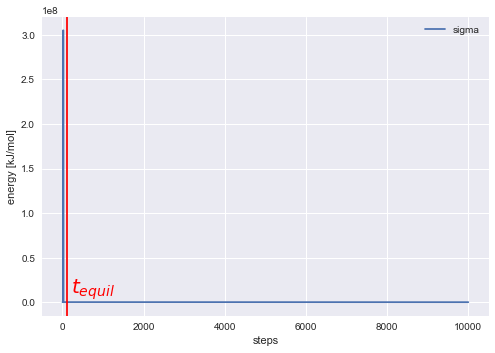

In [7]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.axvline(t, color='red')
plt.text(t+100, 10000000, r'$t_{equil}$', color='red', fontsize=20)
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.savefig('sigma_discrete.pdf')

From the traces of each parameters, you can see how the phases are stuck at 0 and most Ks are random. 

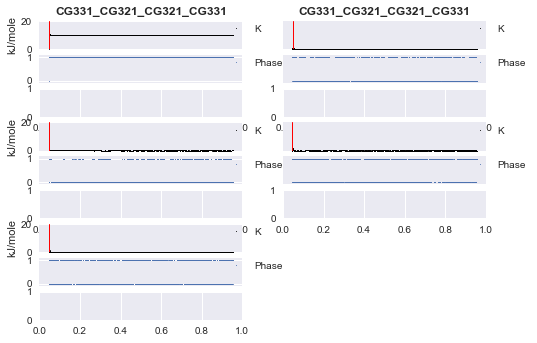

In [8]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, multiplicity_traces=False,
                  filename='traces_discrete.pdf')

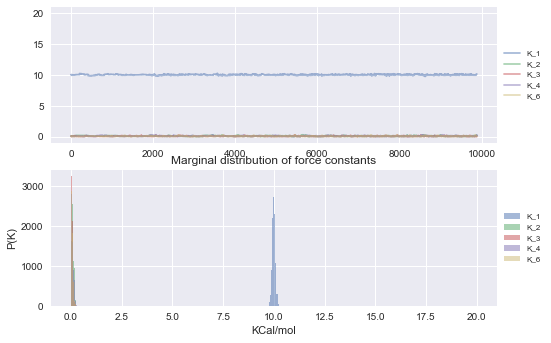

In [14]:
alpha = 0.5
plt.subplot(2, 1, 1)
plt.plot(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_2_K.trace[t:], label='K_2', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_3_K.trace[t:], label='K_3', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6', alpha=alpha)
plt.ylim(-1, 21)
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))


plt.subplot(2, 1, 2)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_2_K.trace[t:], label='K_2', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_K.trace[t:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6', alpha=alpha)
plt.xlim(-1, 21)



lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('Marginal distribution of force constants')
plt.xlabel('KCal/mol')
plt.ylabel('P(K)')
plt.savefig('trace_hist.pdf')

In [10]:
mean = sampler.CG331_CG321_CG321_CG331_1_K.trace[t:].mean()
var = np.var(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:])
print('Mean of K_1: {}'.format(mean))
print('Variance of K_1: {}'.format(var))

Mean of K_1: 10.00410415368272
Variance of K_1: 0.004712002690830998


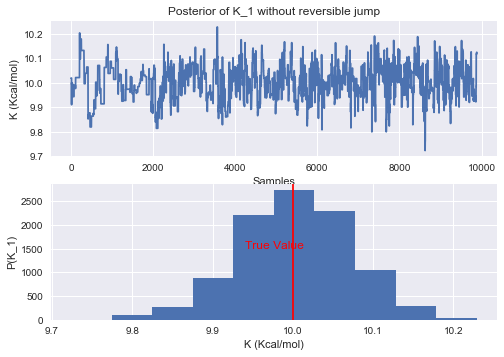

In [15]:
plt.subplot(2, 1, 1)
plt.title('Posterior of K_1 without reversible jump')
plt.plot(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1')
plt.ylabel('K (Kcal/mol)')
plt.xlabel('Samples')
plt.subplot(2, 1, 2)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1')
plt.xlabel('K (Kcal/mol)')
plt.ylabel('P(K_1)')
plt.axvline(toy.true_value[0].phi_k, color='red')
plt.text(toy.true_value[0].phi_k-0.06, 1500, 'True Value', color='red')

plt.savefig('trace_hist_elim_label_on.pdf')

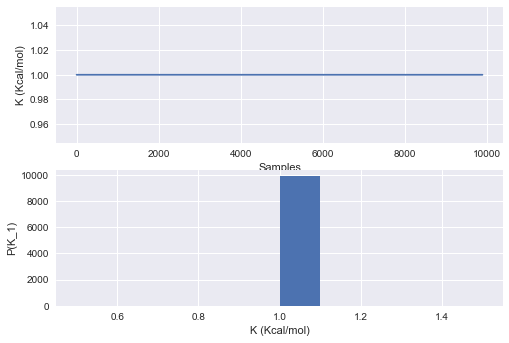

In [13]:
plt.subplot(2, 1, 1)
plt.plot(sampler.CG331_CG321_CG321_CG331_1_Phase.trace[t:], label='K_1')
plt.ylabel('K (Kcal/mol)')
plt.xlabel('Samples')
plt.subplot(2, 1, 2)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_Phase.trace[t:], label='K_1')
plt.xlabel('K (Kcal/mol)')
plt.ylabel('P(K_1)')
#plt.axvline(toy.true_value[0].phase, color='red')
#plt.text(toy.true_value[0].phi_k-0.06, 1500, 'True Value', color='red')
